In [1]:
# 数据准备

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    auc,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)


样本数: 100
前10个样本 (features):
 [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]
前10个标签:
 [0 0 0 0 0 0 0 0 0 0]


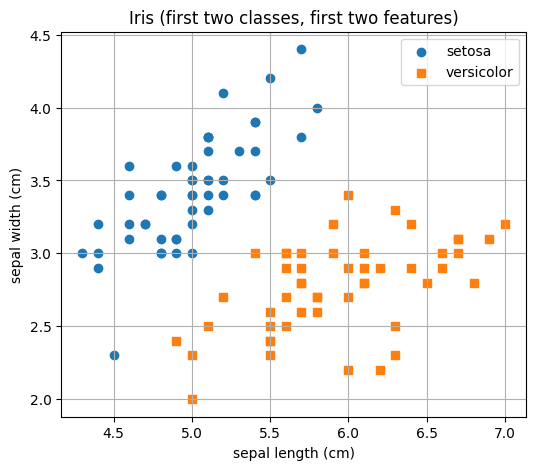

In [2]:
# 数据读取与处理

# 1) 读取 Iris 数据集
# 2) 取前两类（setosa 与 versicolor）作为二分类数据集（每类50个样本，取前两类后总共100个样本）
# 3) 仅取前两个属性（sepal length, sepal width）做二维可视化

iris = datasets.load_iris()
X = iris.data  # shape (150, 4)
y = iris.target  # 0,1,2

# 选择前两类 (标签 0 和 1)
mask = (y == 0) | (y == 1)
X2 = X[mask][:, :2]  # 仅取前两个属性
y2 = y[mask]         # 标签 0 或 1

# 查看数据（示例显示数组的中间部分，用于 notebook 上检查）
print("样本数:", X2.shape[0])
print("前10个样本 (features):\n", X2[:10])
print("前10个标签:\n", y2[:10])

# 可视化：二维散点图（两个类别）
plt.figure(figsize=(6,5))
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], marker='o', label=iris.target_names[0])
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], marker='s', label=iris.target_names[1])
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris (first two classes, first two features)")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# 划分训练集与验证集
# 使用 train_test_split 按 8:2 划分，随机种子 random_state=11
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.2, random_state=11, stratify=y2
)
print("训练集样本数:", X_train.shape[0], "测试集样本数:", X_test.shape[0])

训练集样本数: 80 测试集样本数: 20


In [4]:
# 模型建立与训练

# 使用 sklearn 的 LogisticRegression
# 说明：题目要求 epoch=10 —— scikit-learn 的 LogisticRegression 使用 max_iter 控制迭代次数，
# 我们设 max_iter=10 来满足“epoch=10”的要求（注意：可能导致未完全收敛，但符合实验要求）
# 使用标准化 + LogisticRegression 的 pipeline，设置正则强度C=1.0（默认），solver='lbfgs'
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=1.0, solver='lbfgs', max_iter=10)  # max_iter=10 对应题目中的 epoch=10
)

# 训练模型
model.fit(X_train, y_train)

# 打印模型参数（展示逻辑回归系数与截距）
logreg = model.named_steps['logisticregression']
print("模型系数 (coef_):", logreg.coef_)
print("模型截距 (intercept_):", logreg.intercept_)


模型系数 (coef_): [[ 2.58953676 -2.04844981]]
模型截距 (intercept_): [0.26545813]


In [5]:
# 模型评估 — 计算在测试集上的精度与 F1 值

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # 获取预测为正类的概率

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"测试集 Accuracy: {acc:.4f}")
print(f"测试集 F1-score: {f1:.4f}")


测试集 Accuracy: 1.0000
测试集 F1-score: 1.0000


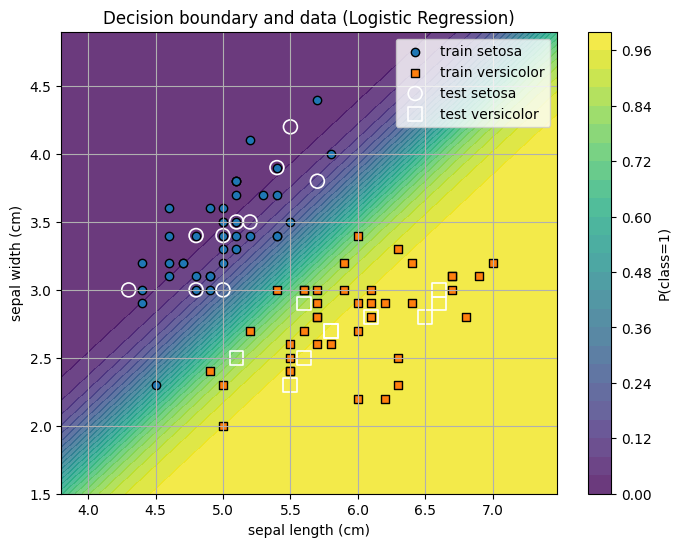

In [6]:
# 可视化决策边界（2D）

# 我们在整个特征范围上生成网格，计算模型在网格上的预测概率，然后等高线绘制决策边界
h = 0.02  # 网格步长
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# pipeline 的 predict_proba 需要同样的两个特征输入
Z = model.predict_proba(grid)[:, 1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
# 使用等高线填充显示概率（决策边界为 0.5）
contour = plt.contourf(xx, yy, Z, levels=25, alpha=0.8)
plt.colorbar(contour, label='P(class=1)')
# 绘制训练数据点
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], edgecolor='k', marker='o', label='train '+iris.target_names[0])
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], edgecolor='k', marker='s', label='train '+iris.target_names[1])
# 绘制测试数据点（用白色边框突出显示）
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], facecolors='none', edgecolor='white', marker='o', s=100, linewidth=1.2, label='test '+iris.target_names[0])
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], facecolors='none', edgecolor='white', marker='s', s=100, linewidth=1.2, label='test '+iris.target_names[1])

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Decision boundary and data (Logistic Regression)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


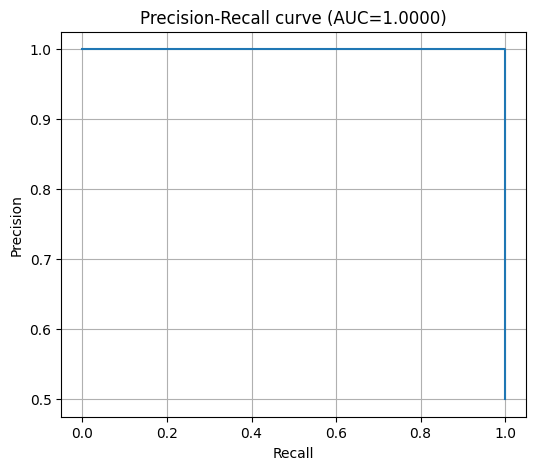

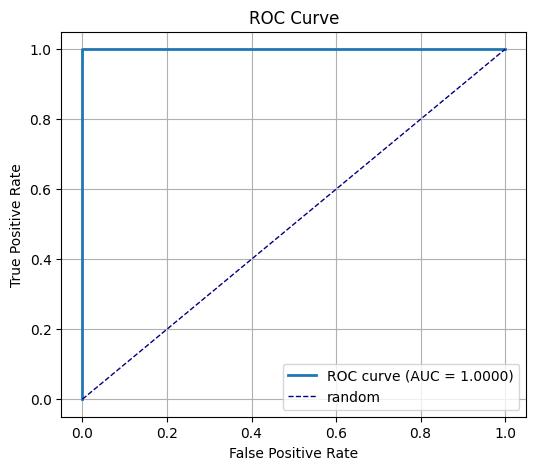

In [7]:
# 绘制 PR 曲线 与 ROC 曲线 并计算 AUC
# Precision-Recall 曲线
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)  # PR AUC

plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AUC={pr_auc:.4f})')
plt.grid(True)
plt.show()

# ROC 曲线
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [8]:
# 另外输出更完整的评价指标（可选）
from sklearn.metrics import classification_report
print("Classification report (test set):")
print(classification_report(y_test, y_pred, target_names=[iris.target_names[0], iris.target_names[1]]))


Classification report (test set):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

